In [1]:
import os
os.chdir('../../src/')
from visualization.SIR_Plot import make_SIR_graph, make_beds_graph

In [2]:
os.chdir('models')
import simulate_pandemic as simp
from actions import costs, city_restrictions
from MCFS import mcts, treeNode
from CMDP import CovidState

Loading Graph...Done!


In [3]:
from tqdm import tqdm
import numpy as np
import pickle as pkl
import datetime
import pandas as pd

In [4]:
import plotly.graph_objects as go
import pandas as pd

def make_beds_graph(data, actions, step_size, title, max_range=None, color_map=None, make_df=True):
    fig = go.Figure()
    
    if make_df:
        data = pd.DataFrame([pd.Series(d).value_counts() for d in data] + [pd.Series(data[-1]).value_counts()])
        data.fillna(0, inplace=True)
        data

    color_map = {
        'Lockdown':          'rgb(0.83, 0.13, 0.15)',
        'Hard Quarantine':    'rgb(0.85, 0.35, 0.13)',
        'Light Quarantine':   'rgb(0.97, 0.91, 0.56)',
        'Social Distancing':  'rgb(0.67, 0.88, 0.69)',
        'Unrestricted':        'rgb(0.86, 0.86, 0.86)'    
    }

    pop = 55492
    
    actions = list(map(len,  actions))
    
    
    x = list(range(len(data) + 1))
    
    #\definecolor{royalblue(web)}{rgb}{0.25, 0.41, 0.88}
    fig.add_trace(go.Scatter(x=x, y=data[3]/pop, name='hospitalized', line_color = 'rgb(0.25, 0.41, 0.88)',
                            line=dict(width=3.5),  
                            ))
    
    fig.add_trace(go.Scatter(x=x, y=(len(data))*[0.0015], name='capacity', line_color = 'black',
                            line=dict(dash='dash', width = 2),
                            ))
    # ACTIONS BACKGROUND################################################################################
    """fig.update_layout(
        shapes=[
            dict(
                type="rect",
                # x-reference is assigned to the x-values
                xref="x",
                # y-reference is assigned to the plot paper [0,1]
                yref="paper",
                x0=(step_size*i),
                y0=0,
                x1=step_size*(i+1),
                y1=1,
                fillcolor=a,
                opacity=0.45,
                layer="below",
                line_width=0,
            ) for i,a in enumerate(actions)]
    )"""

    fig.update_layout(xaxis={'showgrid': False,},
                      yaxis = {'showgrid': False, 'zeroline': False,},
                      showlegend=True, hovermode="x")
    
    fig.update_layout(
        xaxis = dict(
            tickmode = 'array',
            tickvals = list(range(0, len(data)+1, 14)),
            ticktext = list(range(0, int(len(data)/7) + 1, 2)),
            title = 'Weeks',
            )
        )
    fig.update_layout(showlegend=False,
        plot_bgcolor='rgb(255,255,255)',
        margin=dict(
        l=50,
        r=50,
        b=50,
        t=50,
        pad=0
    ))
    
    fig.update_yaxes(automargin=True)
    fig.write_image(f"{title}.pdf")

    fig.show()
    
    return data

In [18]:
import numpy as np
import networkx as nx
from tqdm import tqdm
from disease_states import states_dict
from patient_evolution import susceptible_to_exposed, change_state
from actions import city_restrictions
from collections import defaultdict
from zone_references import initial_districts
import json

print('Loading Graph...',  end='')
G = nx.read_gpickle('../../data/processed/SP_multiGraph_Job_Edu_Level.gpickle')
print('Done!')

with open('../../data/processed/zones_degrees.json', 'r') as f:
    regions_degree = json.load(f)

regions_degree = {int(k): v for k,v in regions_degree.items()}

prhome = 0.06
p_r = {
    'home'    :  prhome,
    'neighbor':  .1*prhome,
    'work'    :  .1*prhome,
    'school'  :  .15*prhome,
}

def init_infection(pct=.0005, return_contacts_infected = False):
    """
    Given a Graph G, infects pct% of population and set the
    remainder as susceptible. This is considered day 0.

    Args:
        pct (float): percentage of people initially infected.

    Returns:
        new_matrix (np.array): 2D Array  arrays of id, state, day of infection
            and current state duration of population.
    """

    global G

    sample_size = int(np.ceil(len(G.nodes()) * pct/len(initial_districts)))
    size = max(sample_size, 1)

    infected = []
    for zones in initial_districts.values():
        init_nodes = ([x for x, v in G.nodes(data=True) 
                           if v['home'] in zones])

        infected.extend(list(np.random.choice(init_nodes, size=size, replace=False)))

    pop_matrix = np.array([[node, states_dict['susceptible'],
                            -1, -1, data['age']]
                          for node, data in G.nodes(data=True)])
    
    contacts_infected = defaultdict(int)

    matrix_change = pop_matrix[np.isin(pop_matrix[:, 0], infected)]

    matrix_keep = pop_matrix[~np.isin(pop_matrix[:, 0], infected)]

    matrix_change = np.apply_along_axis(susceptible_to_exposed,
                                        1, matrix_change, day=0)

    new_matrix = np.concatenate((matrix_keep, matrix_change))
    assert new_matrix.shape == pop_matrix.shape

    if return_contacts_infected:
        return new_matrix, contacts_infected

    else:
        return new_matrix

def expose_population(pop_matrix, exposed, day):
    """
    Receives the population matrix, an array containing ids of newly
    exposed individuals and the current simulation day

    Args:
        pop_matrix (np.array): 2D Array  arrays of id, state, day of infection
            and current state duration of population.

        exposed (list): list of newly exposed people id
        day (int): current simulation day

    Returns:
        new_matrix (np.array): The population matrix with the
        newly exposed people exposed.
    Raises:
        ValueError: If shape of starting matrix is different from final matrix
    """
    matrix_change = pop_matrix[np.isin(pop_matrix[:, 0], exposed)]
    matrix_keep = pop_matrix[~np.isin(pop_matrix[:, 0], exposed)]
    matrix_change = np.apply_along_axis(susceptible_to_exposed,
                                        1, matrix_change, day=day)

    new_matrix = np.concatenate((matrix_keep, matrix_change))

    if new_matrix.shape != pop_matrix.shape:
        raise ValueError("Input and output matrix shapes are different")
    return new_matrix


def lambda_leak_expose(pop_matrix, day, lambda_leak=0.00005):
    """
    Receives the population matrix, the current day and the leak factor.
    Chooses at random a lambda_leak percentage of the population to expose

    Args:
        pop_matrix (np.array): 2D Array  arrays of id, state, day of infection
            and current state duration of population.

        lambda_leak (float): the percentage of the population to expose

        day: the current day of simulation

    Returns:
        new_matrix (np.array): The population matrix with the
                               newly exposed people.
    Raises:
        ValueError: If shape of starting matrix is different from final matrix
    """
    size = int(pop_matrix.shape[0]*lambda_leak)
    susceptible = pop_matrix[pop_matrix[:, 1] == states_dict['susceptible']][:, 0]

    exposed = np.random.choice(susceptible, size=size, replace=False)

    if len(exposed) == 0:
        return pop_matrix

    new_matrix = expose_population(pop_matrix, exposed, day)

    if new_matrix.shape != pop_matrix.shape:
        raise ValueError("Input and output matrix shapes are different")

    return new_matrix



def spread_through_contacts(spreader, restrictions, restricting_zones):
    """
    An infected person, or a spredear, infects each of
    its contacts with chance equal to
    np.random.random() < p_r[r] * (1 - restrictions[r]).
    Returns an array of all the people successfully infected by the spreader.

    Args:
        spreader (int): id of the infected person that is
                        spreading the disease.

        restrictions (dictionary): a dictionary with a value between
                                   zero and one for each type of relation

    Returns:
        infected (list): List of all the people infected by spreader.
    """
    global G, p_r
    spreader = spreader
    if not restricting_zones:
        contacts = [[y, v['edge_type']] for x, y, v
                    in G.edges(spreader, data=True)]

        infected = [y for r in restrictions.keys() for y, v in contacts
                    if v == r
                    and np.random.random() < p_r[r] * (1 - restrictions[r])]
    
    else:
        contacts = [[y, v['edge_type']] for x, y, v
                    in G.edges(spreader, data=True) if v['zone'] not in restrictions
                                                    or v['edge_type'] in ['home', 'neighbor']]

        infected = [y for y, v in contacts if np.random.random() < p_r[v]]
    
        
        
    return infected


def update_population(pop_matrix):
    """
    Receives the population matrix and progress the infections
    for all people. The state duration is decremented
    and for those whom it reaches zero, they transition to the next state

    Args:
        pop_matrix (np.array): 2D Array  arrays of id, state, day of infection
            and current state duration of population.

    Returns:
        new_matrix (np.array): The population matrix with the updated status.
    Raises:
        ValueError: If shape of starting matrix is different from final matrix
    """
    matrix_keep = pop_matrix[np.isin(pop_matrix[:, 1],
                                     [states_dict['susceptible'],
                                     states_dict['removed']]
                                     )]
    matrix_change = pop_matrix[~np.isin(pop_matrix[:, 1],
                                        [states_dict['susceptible'],
                                        states_dict['removed']]
                                        )]

    matrix_change[:, 3] = matrix_change[:, 3].astype(int) - 1
    matrix_no_change = matrix_change[matrix_change[:, 3].astype(int) > 0]
    matrix_change = matrix_change[matrix_change[:, 3].astype(int) == 0]

    if matrix_change.shape[0] > 0:
        matrix_change = np.apply_along_axis(change_state, 1, matrix_change)

    new_matrix = np.concatenate((matrix_keep, matrix_change, matrix_no_change))

    if new_matrix.shape != pop_matrix.shape:
        raise ValueError("Input and output matrix shapes are different")
    return new_matrix



def spread_infection(pop_matrix, restrictions, day, restricting_zones=False, contacts_infected=None):
    """
    Receives the population matrix, the restrictions dictionary and the
    current day. The disease spreads throught the relations in the graph:
    each infected person has a chance to infect a susceptible contact with
    it has an edge in the graph, conditioned to the current restrictions,
    the p_r of each relation.

    Args:
        pop_matrix (np.array): 2D Array  arrays of id, state, day of infection
            and current state duration of population.

        restrictions (dictionary): a dictionary with a value between
        zero and one for each type of relation

        day: the current day of simulation

    Returns:
        new_matrix (np.array): The population matrix with the newly
                                exposed people.
    Raises:
        ValueError: If shape of starting matrix is different from final matrix
    """
    global G
    mask = pop_matrix[:, 1] == states_dict['infected']
    currently_infected = pop_matrix[mask][:, 0]

    if currently_infected.shape[0] == 0:
        if contacts_infected is not None:
            return pop_matrix, contacts_infected
        else:
            return pop_matrix
        
    exposed = []
    for spreader in currently_infected:
        exp = spread_through_contacts(spreader, restrictions, restricting_zones)
        exp = [e for e in exp if e not in exposed]
        if contacts_infected is not None:
            contacts_infected[spreader] += len(exp)
        exposed.extend(exp)
        
    exposed = np.unique(exposed)

    mask = np.isin(pop_matrix[:, 0], exposed)
    susceptible = np.isin(pop_matrix[np.array(mask)][:, 1],
                          states_dict['susceptible'])
    exposed = pop_matrix[np.array(mask)][:, 0][susceptible]

    if len(exposed) == 0:
        if contacts_infected is not None:
            return pop_matrix, contacts_infected
        else:
            return pop_matrix
        

    new_matrix = expose_population(pop_matrix, exposed, day)

    if new_matrix.shape != pop_matrix.shape:
        raise ValueError("Input and output matrix shapes are different")


    if contacts_infected is not None:
        return new_matrix, contacts_infected
    else:
        return new_matrix
        


def main(policy='Unrestricted', days=500):
    """
    Receives the policy to be used during the simulation and for how many days
    the simulation should run for. The policy should be a Key in the policies
    dict inside policies.py.

    One full step consists of:
        Spreading the infection
        Exposing through leakage
        Updating the disease evolution of the population

    Args:
        pop_matrix (string): The name of a policy that exists is policies.policies.

        days (int): For how long should the policy run.


    Returns: data (np.array): An array of arrays containing the status of 
    the population at each time step.
    
    """

    pop_matrix = init_infection(.0001)

    data = []

    # restrictions={'work':0, 'school': 0, 'home':0, 'neighbor':0}
    restrictions = city_restrictions[policy]

    for day in tqdm(range(1, days)):
        # if less than 90% already recovered, break simulation
        if (pop_matrix[pop_matrix[:, 1] == -1].shape[0] > pop_matrix.shape[0]*.9):
            break

        pop_matrix = spread_infection(pop_matrix, restrictions, day)
        pop_matrix = lambda_leak_expose(pop_matrix, day)
        pop_matrix = update_population(pop_matrix)

        data.append(pop_matrix[:, 0:2])

    return data, pop_matrix

Loading Graph...Done!


In [112]:
def run_full_mcst(rolloutPolicy='rolloutPolicy', horizon=1, bruteForce=False,
                  sims_per_leaf=10, n_jobs = 6, step_size = 7, days = 210, capacity=0.0015):

    pop_matrix = init_infection()
    data = []
    actions = []
    alpha = 0.5

    for day in tqdm(range(1, days+1)):
        #if less than 20% still susceptible, break simulation
        if pop_matrix[np.where(pop_matrix[:,1] == -1)].shape[0] > pop_matrix.shape[0]*.9: break            
            
        
        # Choose a new policy at each week
        if day % step_size == 1:     
            infected = (pop_matrix[pop_matrix[:,1] == 2].shape[0]/(len(pop_matrix)*10))*alpha
            top_k = int(np.ceil(min(infected/capacity, 1) * len(regions_degree))) 
            restrictions = top_infected_regions(pop_matrix, regions_degree, top_k)
            actions.append(restrictions)

        pop_matrix = spread_infection(pop_matrix, restrictions, day, restricting_zones=True)
        pop_matrix = lambda_leak_expose(pop_matrix, day)
        pop_matrix = update_population(pop_matrix)

        data.append(np.array(sorted(pop_matrix,key=lambda x: x[0]))[:,1]) 
    
    return data, actions

In [113]:
def top_infected_regions(pop_matrix, regions_degree, top_k=10):
    nodes = pop_matrix[pop_matrix[:,1] == 2][:,0]
    regions_counts = defaultdict(int)
    for n in nodes:
        v = G.nodes[n]
        if not np.isnan(v['work']):
            regions_counts[int(v['work'])] +=1
        if not np.isnan(v['school']):
            regions_counts[int(v['school'])] +=1
    #regions_scores = sorted([(k, (regions_degree[k]*v)) for k,v in regions_counts.items()], key= lambda x: x[1], reverse=True)
    regions_scores = sorted([(k, v) for k,v in regions_counts.items()], key= lambda x: x[1], reverse=True)
    regions_scores = np.array(regions_scores)
    
    if len(regions_scores) == 0:
        return []
    if len(regions_scores) > top_k:
        return (regions_scores[:,0][:top_k])
    return regions_scores[:,0]

In [114]:
horizon = 4
sims = 6
days = 280
bf = False

data, actions = run_full_mcst(horizon=horizon, sims_per_leaf=sims, days=days, step_size=7, n_jobs=6, bruteForce=bf)

date = datetime.datetime.now()
date_str = f'{date.month}_{date.day}_{date.hour}_{date.minute}'

df = make_beds_graph(data, [], 7, f'../../data/MCTS_Results/plots/top_zones_without_degree')

#with open(f'../../data/MCTS_Results/pickles/looser_cost_H{horizon}_N{sims}_D{days}_bf{bf}_{date_str}', 'wb') as f:
#    pkl.dump((data, actions, tree), f)

100%|████████████████████████████████████████████████████████████████████████████████| 280/280 [00:56<00:00,  5.00it/s]


In [115]:
closed_regions = defaultdict(int)

for a in actions:
    for r in a:
        closed_regions[r] += 1

In [145]:
mostly_affected = sorted(list(closed_regions.items()), key= lambda x: x[1], reverse=True)[-10:]

In [147]:
distritos = pd.read_csv('../../data/processed/distritos.csv', sep=';')
dist_dict = distritos.set_index('zona')['nome'].to_dict()

In [148]:
pd.DataFrame(list(map(lambda x: (dist_dict[x[0]], x[1]), mostly_affected)), columns=['Regiao', 'Semanas fechada'])

,Regiao,Semanas fechada
0,Vila Cardoso Franco,3
1,Parque do Estado,3
2,Vila Natal,3
3,Jardim das Pedras,2
4,Parque Anhembi,2
5,Jardim Maria do Carmo,2
6,São João Clímaco,2
7,Pedro José Nunes,2
8,Tamanduateí,2
9,Marsilac,1


In [130]:
len(regions_degree)


338

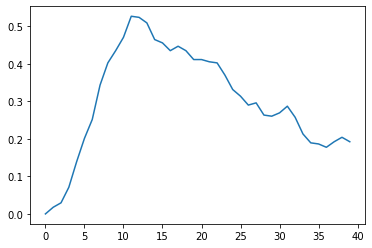

In [131]:
import matplotlib.pyplot as plt
plt.plot(range(0, len(actions)), list(map(lambda x: len(x)/338, actions)))